# Importing Libraries, preprocessing images

In [1]:
!pip install window

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

import shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
np.random.seed(123)
from keras.models import load_model

# import Functions

from keras.applications import inception_v3
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

Checking the sizes of the images in the dataset

In [8]:
def getImageSizes(folder_path):
    '''
    Takes in a specified folder path and returns a list of sizes for each file in the folder
    '''
    file_size = []

    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            if file == '.DS_Store':
                continue
                
            f = os.path.join(dirpath, file)
            
            im = Image.open(f)
            width, height = im.size
            
            file_size.append((width, height))
    return file_size
 

In [9]:
f_img = Image.open('../Data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
f_width, f_height = f_img.size
(f_width, f_height)

(2090, 1858)

In [10]:
train_norm_sizes = getImageSizes('../Data/chest_xray/chest_xray/train/NORMAL')
train_pneum_sizes = getImageSizes('../Data/chest_xray/chest_xray/train/PNEUMONIA')

val_norm_sizes = getImageSizes('../Data/chest_xray/chest_xray/val/NORMAL')
val_pneum_sizes = getImageSizes('../Data/chest_xray/chest_xray/val/PNEUMONIA')

test_norm_sizes = getImageSizes('../Data/chest_xray/chest_xray/test/NORMAL')
test_pneum_sizes = getImageSizes('../Data/chest_xray/chest_xray/test/PNEUMONIA')


In [11]:
train_norm_sizes[:5]

[(2359, 2234), (1422, 1067), (1828, 1357), (1854, 1495), (2194, 1966)]

Navigating to the correct folder and extracting images, converting them to numpy arrays

In [12]:
def convertImages(tr_dir,val_dir,test_dir, size=(256,256)):
    '''
    returns scaled numpy arrays of images and their labels
    like so (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)
    '''
    
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            val_dir, batch_size=16, target_size=size)

    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            tr_dir,batch_size=5216, target_size=size)

    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
            test_dir, batch_size=624, target_size=size)

    train_images, train_labels = next(train_generator)
    val_images, val_labels = next(val_generator)
    test_images, test_labels = next(test_generator)
    
    
    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [13]:
train_data_dir = '../Data/chest_xray/chest_xray/train'
val_data_dir = '../Data/chest_xray/chest_xray/val'
test_data_dir = '../Data/chest_xray/chest_xray/test'

In [10]:
# size 1000*1000 - this keeps breaking the kernal
# train_images_1000, train_labels_1000, val_images_1000, val_labels_1000, test_images_1000, test_labels_1000 = convertImages(train_data_dir,val_data_dir,test_data_dir,size=(1000,1000))


In [25]:
# size 500*500
# train_images_500, train_labels_500, val_images_500, val_labels_500, test_images_500, test_labels_500 = convertImages(train_data_dir,val_data_dir,test_data_dir,size=(500,500))

In [1]:
# size 256*256
# train_images, train_labels, val_images, val_labels, test_images, test_labels = convertImages(train_data_dir,val_data_dir,test_data_dir,size=(256,256))

Using the standard 256 * 256

In [14]:
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, batch_size=16)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir,batch_size=5216)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, batch_size=624)

# Creating the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Checking the mapping of the classes to ensure they are all pointing to same folder

In [17]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [18]:
print('train size',train_images.shape)
print('val size ',val_images.shape)
print('test size ',test_images.shape)

train size (5216, 256, 256, 3)
val size  (16, 256, 256, 3)
test size  (624, 256, 256, 3)


A quick investigation shows that the three RGB layers are all the same so we can cut it down.

In [19]:
print(train_images[3][0][0])
print(train_images[40][0][0])

[0.05490196 0.05490196 0.05490196]
[0.7137255 0.7137255 0.7137255]


In [20]:
train_images[:,:,:,0].shape

(5216, 256, 256)

In [21]:
train_images = train_images[:,:,:,0]
val_images = val_images[:,:,:,0]
test_images = test_images[:,:,:,0]

Find which labels represent which images

In [22]:
print('There are ',sum(train_labels[:,1]),'instances of pneumonia in the training set and ',
      (len(train_labels) - sum(train_labels[:,1])),'instances of healthy lungs')
print('There are ',sum(val_labels[:,1]),'instances of pneumonia in the validation set and',
     (len(val_labels) - sum(val_labels[:,1])),'instances of healthy lungs')
print('There are ',sum(test_labels[:,1]),'instances of pneumonia in the testing set and',
     (len(test_labels) - sum(test_labels[:,1])),'instances of healthy lungs')

There are  3875.0 instances of pneumonia in the training set and  1341.0 instances of healthy lungs
There are  8.0 instances of pneumonia in the validation set and 8.0 instances of healthy lungs
There are  390.0 instances of pneumonia in the testing set and 234.0 instances of healthy lungs


In [23]:
# selecting the correct class for the sets
train_labels_final = train_labels[:,1]
val_labels_final = val_labels[:,1]
test_labels_final = test_labels[:,1]

## Quick Visualization of the two classes

In [467]:
train_labels_final[5083]

1.0

In [464]:
sick_img = array_to_img(train_images[:,:,:,np.newaxis][5083])

In [480]:
sick_img.save('Sick_lungs.png')

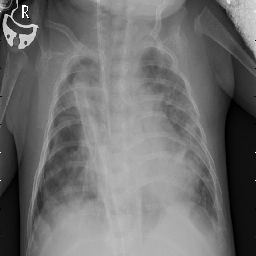

In [466]:
sick_img

In [468]:
train_labels_final[800]

0.0

In [469]:
healthy_img = array_to_img(train_images[:,:,:,np.newaxis][800])

In [481]:
healthy_img.save('Healthy_lungs.png')

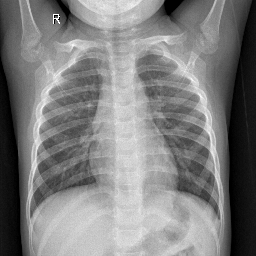

In [471]:
healthy_img

In [24]:
all_labels = np.concatenate([train_labels_final,test_labels_final,val_labels_final])

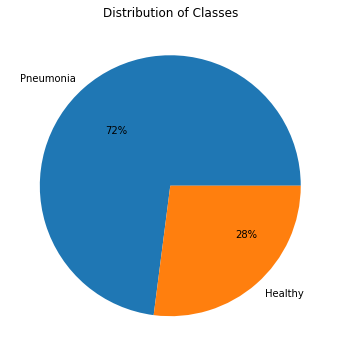

In [25]:
plt.figure(figsize=(8,6));
plt.text(-.5,.4,'72%')
plt.text(.5,-.4,'28%')
plt.pie([sum(all_labels == 1),sum(all_labels == 0)],labels=['Pneumonia','Healthy']);
plt.title('Distribution of Classes');
plt.show()
# plt.savefig('pie_chart_class_dist')

# Modeling

- __Subset__ First let's make a subset of the training images so we don't have to run the CNN on the entire set
<br>
- __Scoring__ In this case we don't want to mistaken any infected patients as healthy, therefore the main scoring metric we'll use will be 'Recall' (out of all real life positives (that is positive to having the infection) how many did we get).<br>


### Subset

In [179]:
df_training = pd.Series(train_labels_final)
df_training_pneum_indices = df_training[df_training ==1].index
df_training_norm_indices = df_training[df_training ==0].index

In [188]:
# select random 250 indices from patients with pneumonia and 250 random indices of healthy patients
subset_indices_norm = np.random.choice(df_training_norm_indices,size=250,replace=False)
subset_indices_pneum = np.random.choice(df_training_pneum_indices,size=250,replace=False)
subset_indices = np.concatenate([subset_indices_norm, subset_indices_pneum])

In [205]:
sub_x_train = []

for count,x in enumerate(train_images):
    if count in subset_indices:
        sub_x_train.append(x)

In [209]:
sub_y_train = []

for count,x in enumerate(train_labels_final):
    if count in subset_indices:
        sub_y_train.append(x)

In [211]:
sub_x_train = np.array(sub_x_train)
sub_y_train = np.array(sub_y_train)

In [213]:
print(sub_x_train.shape)
sub_y_train.shape

(500, 256, 256)


(500,)

In [214]:
sub_x_train = sub_x_train[:,:,:,np.newaxis]

In [218]:
sub_x_train.shape

(500, 256, 256, 1)

In [215]:
val_images = val_images[:,:,:,np.newaxis]

In [223]:
val_images.shape

(16, 256, 256, 1)

> Great, now we have a subset of our training data with 250 infected and 250 healthy x - ray images.<br> Time to model...

____

### CNN1

For the first model we'll be using a total of 6 layers and MAX pooling. 

In [237]:
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256,1)))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(32, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

cnn1.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [238]:
cnn1.fit(sub_x_train,
        sub_y_train,
        epochs=4,
        batch_size=50,
        validation_data=(val_images, val_labels_final))

Train on 500 samples, validate on 16 samples
Epoch 1/4
500/500 [==============================] - 21s 42ms/step - loss: 0.6882 - acc: 0.5100 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 2/4
500/500 [==============================] - 19s 38ms/step - loss: 0.6670 - acc: 0.6460 - val_loss: 0.6701 - val_acc: 0.5625
Epoch 3/4
500/500 [==============================] - 19s 37ms/step - loss: 0.6403 - acc: 0.6980 - val_loss: 0.6546 - val_acc: 0.6875
Epoch 4/4
500/500 [==============================] - 19s 38ms/step - loss: 0.6342 - acc: 0.6380 - val_loss: 0.6332 - val_acc: 0.6875


In [474]:
cnn1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 125, 32)      18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                3936288   
_________________________________________________________________
dense_16 (Dense)             (None, 1)               

### CNN1 Scores

In [257]:
print('The testing set has {:.2%}'.format(test_labels_final.sum()/len(test_labels_final)),'percent infected patients')

The testing set has 62.50% percent infected patients


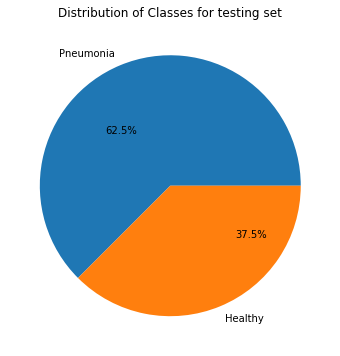

In [26]:
plt.figure(figsize=(8,6));
plt.text(-.5,.4,'62.5%')
plt.text(.5,-.4,'37.5%')
plt.pie([sum(test_labels_final == 1),sum(test_labels_final == 0)],labels=['Pneumonia','Healthy']);
plt.title('Distribution of Classes for testing set');
plt.show()

In [242]:
cnn1_preds = cnn1.predict_classes(test_images[:,:,:,np.newaxis])

In [256]:
print('Cnn1 model has a recall of {:.2%}'.format(recall_score(test_labels_final, cnn1_preds)))

Cnn1 model has a recall of 57.95%


In [315]:
confusion_matrix(test_labels_final,cnn1_preds)

array([[222,  12],
       [164, 226]])

Ok, clearly this model isn't good, if we just assigned everyone in the testing set as infected we would have a recall of 62.5%. Time to step it up..

### CNN2

Architect by Alexnet

In [317]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer

cnn2 = models.Sequential()
cnn2.add(InputLayer( input_shape=(256, 256,1)))
#C1
cnn2.add(Conv2D(64, (4, 4),strides=(3,3),padding='valid'))
cnn2.add(Activation('relu'))
#P1
cnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

#C2
cnn2.add(Conv2D(128, (4, 4),strides=(1,1),padding='valid'))
cnn2.add(Activation('relu'))
#P2
cnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))

#C3
cnn2.add(Conv2D(256, (3, 3),strides=(1,1),padding='valid'))
cnn2.add(Activation('relu'))
#C4
cnn2.add(Conv2D(256, (3, 3),strides=(1,1),padding='valid'))
cnn2.add(Activation('relu'))
#C5
cnn2.add(Conv2D(128, (3, 3),strides=(1,1),padding='valid'))
cnn2.add(Activation('relu'))

#P3
cnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding='valid'))
# the model so far outputs 3D feature maps (height, width, features)


# this converts our 3D feature maps to 1D feature vectors
cnn2.add(Flatten())  

#1st fully connectd layer
cnn2.add(Dense(128))
cnn2.add(Activation('relu'))
#Dropout leyer
cnn2.add(Dropout(0.5))

#2nd fully connectd layer
cnn2.add(Dense(32))
cnn2.add(Activation('relu'))
#Dropout leyer
cnn2.add(Dropout(0.5))


cnn2.add(Dense(1))
cnn2.add(Activation('sigmoid'))

cnn2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fitting to the subset

In [309]:
cnn2.fit(sub_x_train,sub_y_train,
            validation_data=(val_images, val_labels_final),
            epochs= 5,
            batch_size = 50)

Train on 500 samples, validate on 16 samples
Epoch 1/5
500/500 [==============================] - 9s 19ms/step - loss: 0.6985 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/5
500/500 [==============================] - 9s 18ms/step - loss: 0.6942 - accuracy: 0.4780 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
500/500 [==============================] - 9s 18ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
500/500 [==============================] - 10s 19ms/step - loss: 0.6942 - accuracy: 0.4600 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
500/500 [==============================] - 9s 19ms/step - loss: 0.6937 - accuracy: 0.4820 - val_loss: 0.6931 - val_accuracy: 0.5000


### CNN2 Scoring (fitted to subset)

In [311]:
cnn2_preds = cnn2.predict_classes(test_images[:,:,:,np.newaxis])

In [312]:
recall_score(test_labels_final,cnn2_preds)

0.0

In [313]:
accuracy_score(test_labels_final,cnn2_preds)

0.375

In [314]:
confusion_matrix(test_labels_final,cnn2_preds)

array([[234,   0],
       [390,   0]])

This model failed epically, it classified every test image as a healthy patient!<br>
What happens if we fit it to the entire trainning set, will it improve?

### CNN2 Refit

In [319]:
train_images.shape

(5216, 256, 256)

In [320]:
cnn2.fit(train_images[:,:,:,np.newaxis],train_labels_final,
            validation_data=(val_images, val_labels_final),
            epochs= 6,
            batch_size = 50)

Train on 5216 samples, validate on 16 samples
Epoch 1/6
5216/5216 [==============================] - 135s 26ms/step - loss: 0.6018 - accuracy: 0.7393 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 2/6
5216/5216 [==============================] - 121s 23ms/step - loss: 0.4326 - accuracy: 0.7889 - val_loss: 0.5391 - val_accuracy: 0.8125
Epoch 3/6
5216/5216 [==============================] - 113s 22ms/step - loss: 0.2647 - accuracy: 0.8932 - val_loss: 0.4656 - val_accuracy: 0.7500
Epoch 4/6
5216/5216 [==============================] - 124s 24ms/step - loss: 0.1929 - accuracy: 0.9283 - val_loss: 0.8606 - val_accuracy: 0.7500
Epoch 5/6
5216/5216 [==============================] - 130s 25ms/step - loss: 0.1586 - accuracy: 0.9436 - val_loss: 0.6826 - val_accuracy: 0.6875
Epoch 6/6
5216/5216 [==============================] - 119s 23ms/step - loss: 0.1444 - accuracy: 0.9473 - val_loss: 1.1557 - val_accuracy: 0.6875


### CNN2 Scoring (fitted to entire training set)

In [322]:
cnn2_preds = cnn2.predict_classes(test_images[:,:,:,np.newaxis])

In [323]:
recall_score(test_labels_final, cnn2_preds)

0.9948717948717949

In [324]:
confusion_matrix(test_labels_final, cnn2_preds)

array([[ 99, 135],
       [  2, 388]])

In [325]:
precision_score(test_labels_final, cnn2_preds)

0.7418738049713193

We can see a major upgrade, when we train the cnn2 over the entire training set we get a recall of 99%!

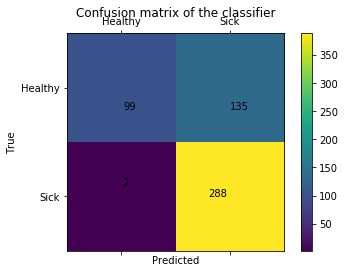

In [56]:
labels = ['Healthy', 'Sick']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.text(.02,.2,99)
plt.text(1,.2,135)
plt.text(.01,.9,2)
plt.text(.8,1,288)
plt.show()

In [ ]:
cnn2.summary()

 ### CNN2 with 25 Epochs

Careful before running this

In [409]:
cnn2_25 = cnn2.fit(train_images[:,:,:,np.newaxis],train_labels_final,
            validation_data=(val_images, val_labels_final),
            epochs= 25,
            batch_size = 50)

Train on 5216 samples, validate on 16 samples
Epoch 1/25
5216/5216 [==============================] - 157s 30ms/step - loss: 0.1168 - accuracy: 0.9586 - val_loss: 0.5451 - val_accuracy: 0.7500
Epoch 2/25
5216/5216 [==============================] - 154s 29ms/step - loss: 0.0986 - accuracy: 0.9653 - val_loss: 0.5973 - val_accuracy: 0.7500
Epoch 3/25
5216/5216 [==============================] - 268s 51ms/step - loss: 0.1042 - accuracy: 0.9630 - val_loss: 0.7150 - val_accuracy: 0.8125
Epoch 4/25
5216/5216 [==============================] - 115s 22ms/step - loss: 0.0791 - accuracy: 0.9722 - val_loss: 1.1022 - val_accuracy: 0.6875
Epoch 5/25
5216/5216 [==============================] - 109s 21ms/step - loss: 0.0713 - accuracy: 0.9758 - val_loss: 0.1356 - val_accuracy: 0.9375
Epoch 6/25
5216/5216 [==============================] - 113s 22ms/step - loss: 0.0632 - accuracy: 0.9772 - val_loss: 0.3176 - val_accuracy: 0.8125
Epoch 7/25
5216/5216 [==============================] - 121s 23ms/step -

### CNN2 25 epochs scoring

In [410]:
cnn2_25_preds = cnn2_25.model.predict_classes(test_images[:,:,:,np.newaxis])

In [411]:
recall_score(test_labels_final, cnn2_25_preds)

0.9974358974358974

In [412]:
precision_score(test_labels_final, cnn2_25_preds)

0.7217068645640075

In [413]:
confusion_matrix(test_labels_final,cnn2_25_preds)

array([[ 84, 150],
       [  1, 389]])

Looks like we have a case of overfit, recall did slightly better but precision dropped by 2 points

## Model Function 

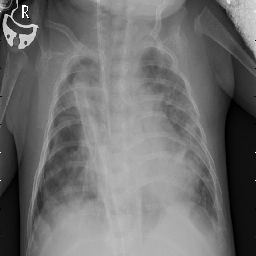

In [517]:
Image.open('../Reports/Sick_lungs.png')

In [506]:
def predict_X_ray(full_image_path):
    '''
    This function takes in the path to a chest x-ray image and returns a 
    classification of 0 or 1, healthy or pneumonia respectively
    '''
    import cv2
    image = cv2.imread(full_image_path)
    
    pred = cnn2.predict(image[np.newaxis,:,:,0,np.newaxis],batch_size=1)
    
    if pred == 1:
        return 'Pneumonia'
    if pred ==0:
        return 'Healthy'

In [518]:
predict_X_ray('../Reports/Sick_lungs.png')

'Pneumonia'